In [1]:
%cd ..
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from melp import Detector
import melp
import math

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt

plt.rcParams.update({'font.size': 16})

/home/erik/GitHub/melp
Welcome to JupyROOT 6.24/06


#### Load files

In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"
filename_sorted_big = "/home/erik/GitLab_KIP/melp/root_files/big_run_data/sorted1.root"
filename_sorted_fix = "./testdata/sorted/sorted1_fixed.root"
#filename_sorted_big = "./testdata/sorted/sorted1_big.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")
ttree_sensor = file.Get("alignment/sensors")
ttree_tiles = file.Get("alignment/tiles")

file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")
ttree_mu3e_segs = file_rec.Get("segs")

#file_big = ROOT.TFile(filename_sorted_big) #not fixed
file_big = ROOT.TFile(filename_sorted_fix)
ttree_mu3e_big = file_big.Get("mu3e")
ttree_mu3e_mc_big = file_big.Get("mu3e_mchits")
ttree_sensor_big = file_big.Get("alignment/sensors")
ttree_tiles_big = file_big.Get("alignment/tiles")


In [3]:
frame = 1
ttree_trirec.GetEntry(frame)
ttree_trirec_mc.GetEntry(frame)

ttree_mu3e.GetEntry(frame)
ttree_mu3e_mc.GetEntry(frame)
   
tid_rec = ttree_trirec.mc_tid
tid_rec_mc = ttree_trirec_mc.mc_tid

tid_counter = 0
for i in tid_rec_mc:
    if i in get_tid_frame(ttree_mu3e, ttree_mu3e_mc).values():
        tid_counter += 1
    else:
        continue

print(tid_counter/(len(get_tid_frame(ttree_mu3e, ttree_mu3e_mc))/100), "%")
print(len(tid_rec_mc)/(len(tid_rec)/100), "%")

10.526315789473685 %
70.0 %


In [4]:
ttree_mu3e_segs.GetEntry(frame)

segs_rec_tid = ttree_mu3e_segs.tl_n

In [5]:
print(segs_rec_tid)

print(tid_rec)

0
{ 28341, 33517, 32299, 34367, 37051, 16492, 16492, 16492, 25876, 25876 }


#### Whole frame as cluster

In [6]:
eff_counter = 0
tot_hit_counter = 0
wrong_counter = 0

eff_counter_arr = []
tot_hit_counter_arr = []
wrong_counter_arr = []

for frame in range(ttree_mu3e.GetEntries()):
    ttree_mu3e.GetEntry(frame)
    tmp_eff_counter = 0
    tmp_tot_hit_counter = 0
    tmp_wrong_counter = 0
    
    primaries = get_mc_primary_for_hit_frame(ttree_mu3e)
    cluster = frame_as_cluster(ttree_mu3e)
    tot_hit_counter += len(cluster)
    tmp_tot_hit_counter += len(cluster)
    for key in cluster.keys():
        if key in primaries.keys():
            if cluster[key] == primaries[key]:
                eff_counter += 1
                tmp_eff_counter += 1
            else:
                wrong_counter += 1
                tmp_wrong_counter += 1
        else:
            continue
        eff_counter_arr.append(tmp_eff_counter)
        tot_hit_counter_arr.append(tmp_tot_hit_counter)
        wrong_counter_arr.append(tmp_wrong_counter)
             
print("Average number of hits per frame: ", tot_hit_counter/ttree_mu3e.GetEntries())
print("Correctly identified: ", eff_counter/(tot_hit_counter/100), "%")
print("Incorrectly identified (not an actual part of cluster): ", wrong_counter/(tot_hit_counter/100), "%")
print("Not identified (actual part of cluster that hasn't been identified): ", 0, "%")

Average number of hits per frame:  15.50653983353151
Correctly identified:  17.345295606165173 %
Incorrectly identified (not an actual part of cluster):  82.65470439383483 %
Not identified (actual part of cluster that hasn't been identified):  0 %


In [7]:
"""
plt.figure(figsize=(18,10))
plt.hist(tot_hit_counter_arr)
plt.hist(wrong_counter_arr)
plt.hist(eff_counter_arr)
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.hist(tot_hit_counter_arr)\nplt.hist(wrong_counter_arr)\nplt.hist(eff_counter_arr)\nplt.show()\n'

In [8]:
"""
plt.figure(figsize=(18,10))
plt.hist(eff_counter_arr + wrong_counter_arr)
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.hist(eff_counter_arr + wrong_counter_arr)\nplt.show()\n'

#### Masks (Small. Medium, Big)

In [9]:
mu3e_detector = Detector.initFromROOT(filename_sorted)
#mu3e_detector = Detector.initFromSave("test_detector_file")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [10]:
#mu3e_detector.save("test_detector_file")

In [11]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=Loaded Tiles: 5824, SensorModules=<melp.src.sensor.SensorModule object at 0x7f6106b04700>))


In [12]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [13]:
#select frame to analyze
frame_used = 30
ttree_mu3e.GetEntry(frame_used)

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks, __ = clump.masks.build_mask_around_cluster_master(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big")

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
#mu3e_detector.TileDetector.tile[keys[0]].id
#mu3e_detector.TileDetector.tile[keys[0]].hits
#print(values[0])

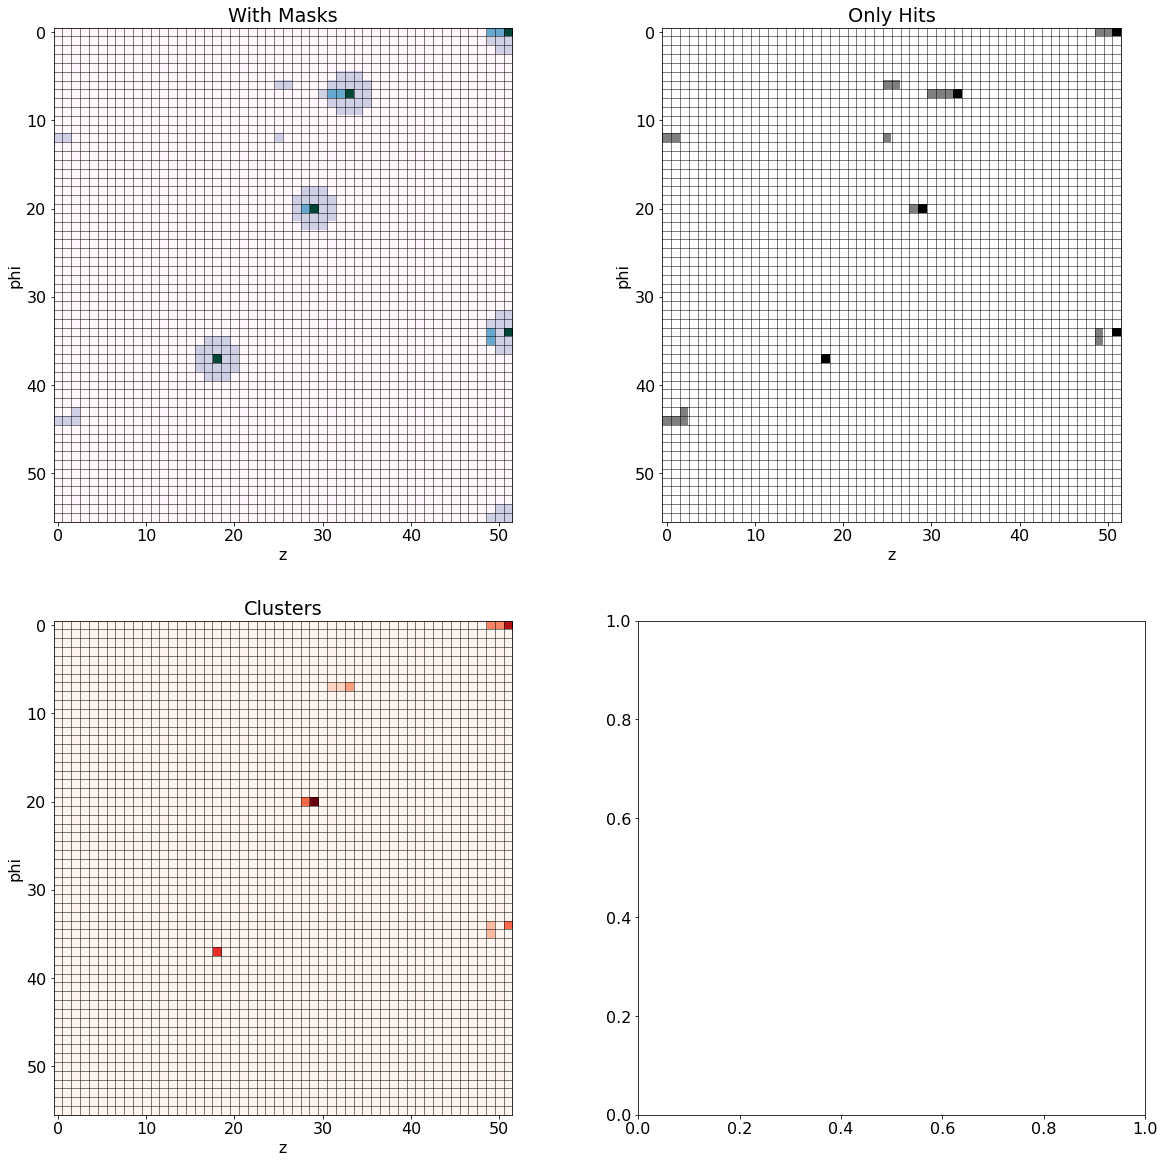

In [14]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot master hits into reference plot(truth)
cluster_master, cluster_master_primary = get_cluster_master_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_master)):
    master = mu3e_detector.TileDetector.tile[cluster_master[i]]
    if master.id < 300000:
        y = master.row()
        x = master.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")


#plot clusters
cluster_grid = np.zeros((52,56))
clusters = clump.spatial_cluster.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector,frame_used, mask_type = "big")
cluster_masters = []
whole_clusters = []
for i in range(len(clusters)):
    cluster_masters.append(clusters[i].master_id)
    whole_clusters.append(clusters[i].get_tile_ids())

color_clusters = 1
for i in range(len(clusters)):
    color_clusters += 1
    for cluster_tile in whole_clusters[i]:
        tile = mu3e_detector.TileDetector.tile[cluster_tile]
        if cluster_tile < 300000:
            y = tile.row()
            x = tile.column()
            cluster_grid[x][y] += i+1

    #add centre    
    if cluster_masters[i] < 300000:
        tile = mu3e_detector.TileDetector.tile[cluster_masters[i]]
        y = tile.row()
        x = tile.column()
        cluster_grid[x][y] += i+1
    
    
heatplot = ax[1,0].imshow(cluster_grid.T, cmap='Reds')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
#plt.savefig("hitmap.png")
plt.show()

In [15]:
hit_data = get_hit_data_frame(ttree_mu3e, ttree_mu3e_mc, [30])

Tile:  202778  hid:  3  tid:  61326 frame_id:  30
Tile:  200100  hid:  5  tid:  58192 frame_id:  30
Tile:  200155  hid:  4  tid:  58192 frame_id:  30
Tile:  200044  hid:  2  tid:  58192 frame_id:  30
Tile:  200156  hid:  3  tid:  58192 frame_id:  30
Tile:  300516  hid:  2  tid:  56141 frame_id:  30
Tile:  300460  hid:  1  tid:  56141 frame_id:  30
Tile:  201045  hid:  1  tid:  53845 frame_id:  30
Tile:  200068  hid:  4  tid:  52493 frame_id:  30
Tile:  202856  hid:  1  tid:  52493 frame_id:  30
Tile:  202744  hid:  3  tid:  52493 frame_id:  30
Tile:  200012  hid:  5  tid:  52493 frame_id:  30
Tile:  202800  hid:  2  tid:  52493 frame_id:  30
Tile:  201588  hid:  2  tid:  48223 frame_id:  30
Tile:  201644  hid:  1  tid:  48223 frame_id:  30
Tile:  202779  hid:  2  tid:  30340 frame_id:  30
Tile:  202890  hid:  1  tid:  14701 frame_id:  30
Tile:  201855  hid:  1  tid:  4389 frame_id:  30
Tile:  201462  hid:  5  tid:  4389 frame_id:  30
Tile:  201406  hid:  6  tid:  4389 frame_id:  30
Til

In [16]:
masters = get_cluster_primary_truth_3frames(ttree_mu3e, ttree_mu3e_mc, frame_used)
print(masters)

[[300001, 29], [202388, 29], [300192, 29], [201871, 29], [202445, 29], [200468, 29], [300447, 29], [200475, 29], [201672, 31], [202361, 31], [202804, 31], [302521, 31], [300460, 30], [201855, 30], [202890, 30], [201045, 30], [202856, 30], [201644, 30]]


## Efficiency Plots

In [17]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 10000)

Progress: 100 % of  10000  framesmes
Number of analyzed frames:  10000 Number of correct counter fractions:  9973
Total #hits in frames/#hits in clusters =  1.7912829605902878
Correctly associated out of all hits:  50.8899319858224 %
Correctly associated out of all hits in clusters:  91.15826803180232 %
Incorrectly associated out of all hits:  4.9359772647443885 %
Incorrectly associated out of all hits in clusters:  8.841731968197678 %


### Hits not included in any cluster

In [18]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 10000)

Progress: 100 % of  10000  framesmes
Not associated hits out of all hits:  44.17409074943322 %


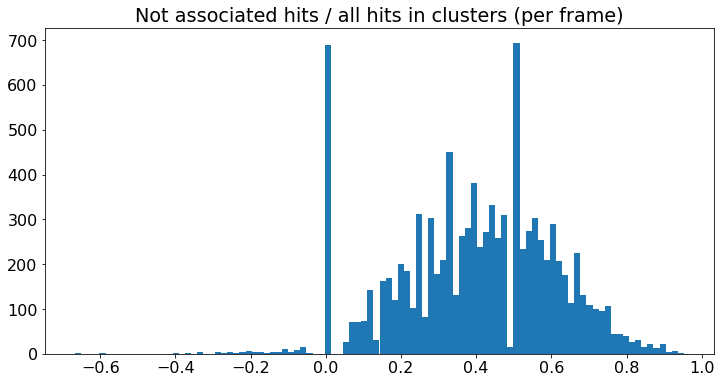

In [19]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

#### Comparing to primary

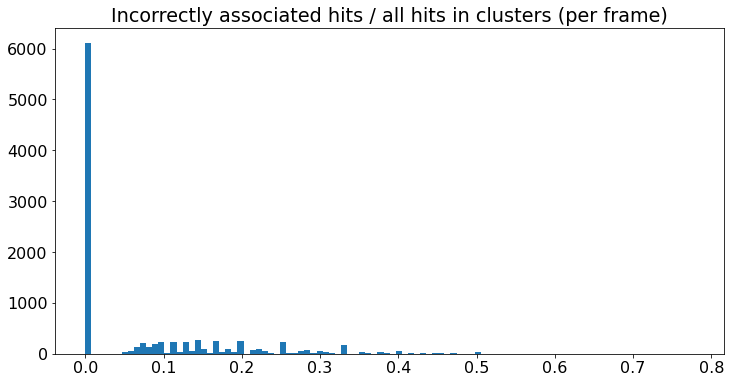

In [20]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

#### Comparing to primary

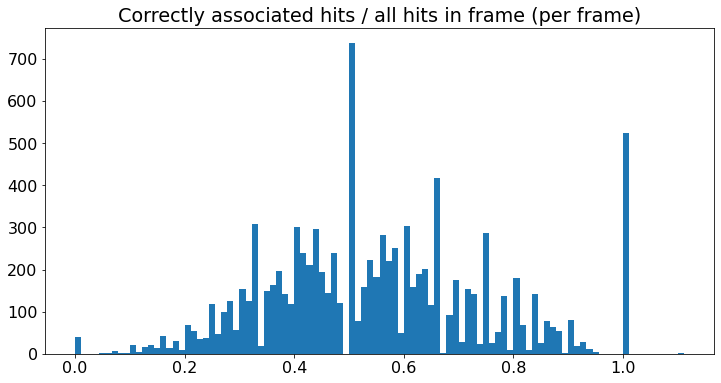

In [21]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

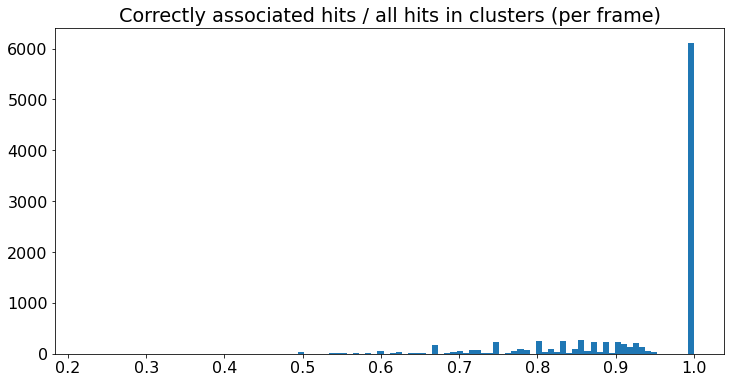

In [22]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

#### Comparing to primary

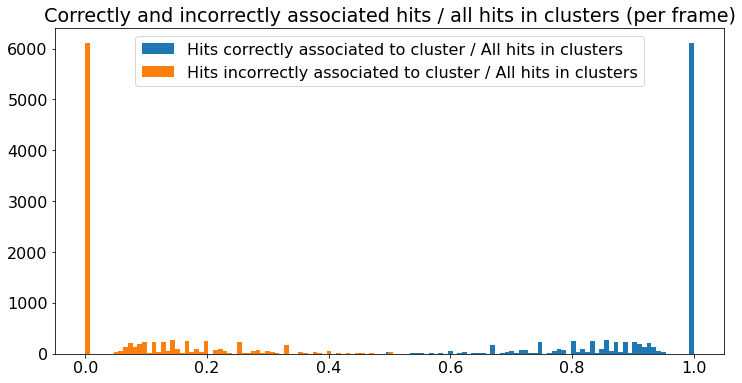

In [23]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()

# Pixel-Pixel Reconstruction

In [24]:
#select frame to analyze
frame_used = 30
ttree_mu3e.GetEntry(frame_used)

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks_pixel_pixel = sclump.build_mask_around_cluster_master(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big", rec_type = "pixelpixelcheck")

keys_pixel_pixel = []
values_pixel_pixel = []
for key in masks_pixel_pixel.keys():
    keys_pixel_pixel.append(key)
    values_pixel_pixel.append(masks_pixel_pixel[key])

AttributeError: module 'melp.clustering.spatial_cluster' has no attribute 'build_mask_around_cluster_master'

In [ ]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    y = tile.row()
                    x = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values_pixel_pixel)):
        for mask_tile in values_pixel_pixel[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                y = tile.row()
                x = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys_pixel_pixel[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys_pixel_pixel[i]]
            y = tile.row()
            x = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values_pixel_pixel[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            y = tile.row()
            x = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys_pixel_pixel[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys_pixel_pixel[single_hit]]
        y = tile.row()
        x = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                y = tile.row()
                x = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_primary = get_cluster_primary_truth_frame(ttree_mu3e, ttree_mu3e_mc, frame_used)  
    
for i in range(len(cluster_primary)):
    primary = mu3e_detector.TileDetector.tile[cluster_primary[i]]
    if primary.id < 300000:
        y = primary.row()
        x = primary.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")


#plot clusters
cluster_grid = np.zeros((52,56))
clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, ttree_sensor, ttree_tiles, mu3e_detector, frame_used, mask_type = "big", rec_type = "pixelpixelcheck")
cluster_primaries = []
whole_clusters = []
for key in clusters.keys():
    cluster_primaries.append(key)
    whole_clusters.append(clusters[key])

color_clusters = 1
for i in range(len(clusters)):
    color_clusters += 1
    for cluster_tile in whole_clusters[i]:
        tile = mu3e_detector.TileDetector.tile[cluster_tile]
        if cluster_tile < 300000:
            y = tile.row()
            x = tile.column()
            cluster_grid[x][y] += i+1

    #add centre    
    if cluster_primaries[i] < 300000:
        tile = mu3e_detector.TileDetector.tile[cluster_primaries[i]]
        y = tile.row()
        x = tile.column()
        cluster_grid[x][y] += i+1
    
    
heatplot = ax[1,0].imshow(cluster_grid.T, cmap='Reds')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
#plt.savefig("hitmap.png")
plt.show()

## Efficiency Plots

In [ ]:
frac_corr_frame_primary, frac_corr_clusters_frame_primary, frac_uncorr_frame_primary, tot_corr_primary = clump_plt.compare_to_primary(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 10000, rec_type = "pixelpixelcheck")

### Hits not included in any cluster

In [ ]:
frac_not_in_cluster = clump_plt.get_hits_not_in_cluster(ttree_mu3e_big, ttree_mu3e_mc_big, ttree_sensor_big, ttree_tiles_big, mu3e_detector, mask_type = "big", number_of_frames = 10000, rec_type = "pixelpixelcheck")

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_not_in_cluster, bins = 100)
plt.title("Not associated hits / all hits in clusters (per frame)")
plt.show()

### Hits associated to wrong cluster

#### Comparing to primary

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_uncorr_frame_primary, bins = 100)
plt.title("Incorrectly associated hits / all hits in clusters (per frame)")
plt.show()

### Hits correctly associated

#### Comparing to primary

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in frame (per frame)")
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100)
plt.title("Correctly associated hits / all hits in clusters (per frame)")
plt.show()

### Combined Histograms

#### Comparing to primary

In [ ]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_clusters_frame_primary, bins = 100, label = "Hits correctly associated to cluster / All hits in clusters")
plt.hist(frac_uncorr_frame_primary, bins = 100, label = "Hits incorrectly associated to cluster / All hits in clusters")
plt.title("Correctly and incorrectly associated hits / all hits in clusters (per frame)")
plt.legend()
plt.show()